In [1]:
#Program executed with 400 cases

import warnings
warnings.filterwarnings("ignore")

#Load dataframe
import numpy as np
import pandas as pd
df = pd.read_pickle("400_cases.pkl")

case_id = df["caseid"].tolist()
#Save column reversed in own list
case_reversed = df["case_reversed"].tolist()
df = df.drop(columns=["caseid", "case_reversed"])

In [2]:
#Use logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

X = df
y = case_reversed

sparse_scaler = StandardScaler(with_mean=False)
X = sparse_scaler.fit_transform(X)

log_reg = LogisticRegression()

yhat = cross_val_predict(log_reg, X, y)

In [3]:
from sklearn.metrics import confusion_matrix

#Print mean-value for the prediction
sk_mean = (y == yhat).mean()
print("Mean value: ", sk_mean)

#Create confusion matrix
m = confusion_matrix(y, yhat)
print ("Confusion martix:\n", m)

Mean value:  0.56
Confusion martix:
 [[ 63  93]
 [ 83 161]]


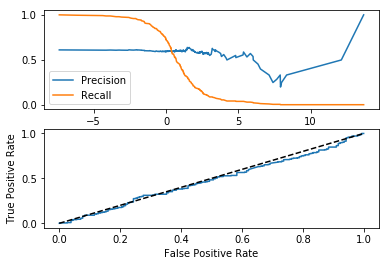

In [15]:
#Print precision recall curve and roc curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

yhat = cross_val_predict(log_reg, X, y, method='decision_function')
metrics = precision_recall_curve(y, yhat)
precisions, recalls, thresholds = metrics
plt.subplot(211)
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()

fpr, tpr, thresholds = roc_curve(y, yhat)
plt.subplot(212)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

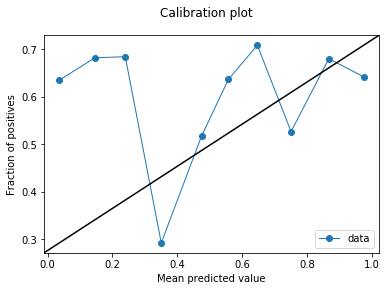

In [5]:
#Calibration plot
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.calibration import calibration_curve

yhat = cross_val_predict(log_reg, X, y, method='predict_proba')
logreg_y, logreg_x = calibration_curve(y, yhat[:,1], n_bins=10)
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='data')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Mean predicted value')
ax.set_ylabel('Fraction of positives')
plt.legend()
plt.show()

In [6]:
#Import metadata
df["caseid"] = case_id

metadata = pd.read_csv('case_metadata.csv')
metadata = metadata.drop(columns=["case_reversed", "year"])
metadata.fillna(0, inplace=True)
df = pd.merge(df, metadata, on="caseid")

judge_id = df["judge_id"].tolist()
log_cites = df["log_cites"].tolist()
df = df.drop(columns=["caseid", "judge_id", "log_cites"])
X = df

In [7]:
#scaling N-grams, although data already scaled
from sklearn.preprocessing import StandardScaler
sparse_scaler = StandardScaler(with_mean=False)
X_sparse = sparse_scaler.fit_transform(X)

#Training elastic net model
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0.01)
enet.fit(X_sparse, log_cites)

log_cites_hat = cross_val_predict(enet, X_sparse, log_cites)

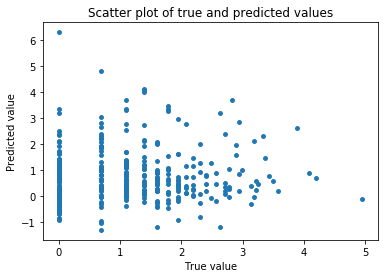

In [8]:
#Scatter plot
plt.scatter(log_cites, log_cites_hat, s=15, alpha=1)
plt.title('Scatter plot of true and predicted values')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

In [9]:
#Train LDA model
tokens = pd.read_pickle("400_tokens.pkl")["tok"]

# randomize document order
from random import shuffle
docs = list(tokens)
shuffle(docs)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(docs)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs]
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


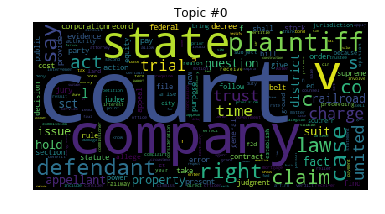

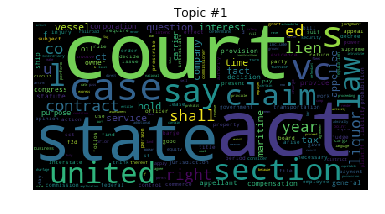

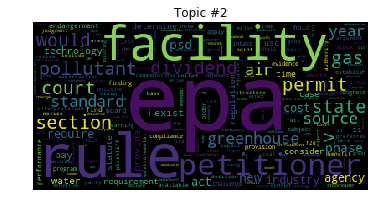

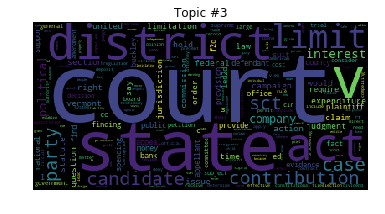

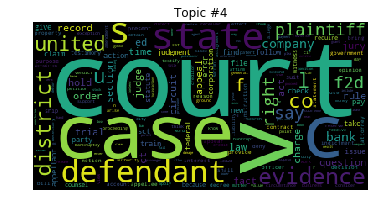

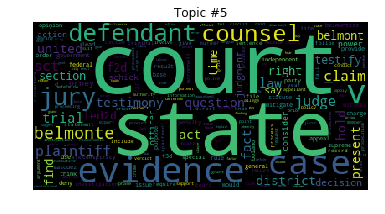

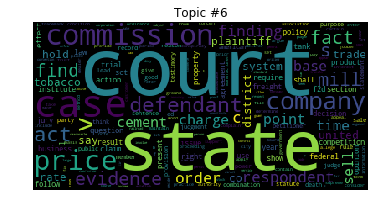

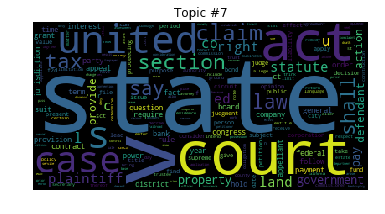

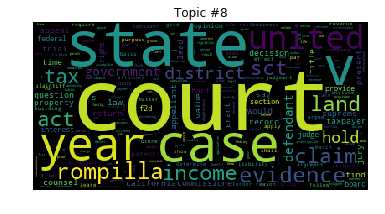

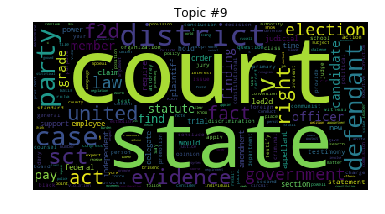

In [10]:
#Creating word clouds for the topics
from wordcloud import WordCloud

for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()
#"state" and "court" are dominating most of the topics

In [11]:
#Create Keras model
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

#Split data in train_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential()
model.add(Dense(50, kernel_regularizer=L1L2(l1=0.0, l2=0.1), input_dim=X.shape[1]))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 320 samples, validate on 80 samples
Epoch 1/3
320/320 [==============================] - 0s 706us/step - loss: 15.8502 - acc: 0.5906 - val_loss: 14.1046 - val_acc: 0.6875
Epoch 2/3
320/320 [==============================] - 0s 78us/step - loss: 15.4867 - acc: 0.5906 - val_loss: 13.7465 - val_acc: 0.6875
Epoch 3/3
320/320 [==============================] - 0s 99us/step - loss: 15.1350 - acc: 0.5906 - val_loss: 13.4025 - val_acc: 0.6875


In [12]:
#Comparing performance
performance = model.evaluate(X_test,y_test)
print("Accuracy of sklearn model: ", sk_mean)
print("Accuracy of keras model: ", performance[1])

80/80 [==============================] - 0s 88us/step
Accuracy of sklearn model:  0.56
Accuracy of keras model:  0.6875


In [13]:
#Add hidden layer: droupout, batch_normalization
from keras.layers import Dropout, BatchNormalization

model = Sequential()
model.add(Dense(50, kernel_regularizer=L1L2(l1=0.0, l2=0.1), input_dim=X.shape[1]))
model.add(Dropout(rate=0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 320 samples, validate on 80 samples
Epoch 1/3
320/320 [==============================] - 0s 1ms/step - loss: 15.9608 - acc: 0.5906 - val_loss: 14.2102 - val_acc: 0.6875
Epoch 2/3
320/320 [==============================] - 0s 85us/step - loss: 15.5905 - acc: 0.5906 - val_loss: 13.8480 - val_acc: 0.6875
Epoch 3/3
320/320 [==============================] - 0s 103us/step - loss: 15.2347 - acc: 0.5906 - val_loss: 13.5000 - val_acc: 0.6875


In [14]:
#Comparing performance
performance2 = model.evaluate(X_test,y_test)
print("Accuracy of sklearn model: ", sk_mean)
print("Accuracy of keras model: ", performance[1])
print("Accuracy of updated keras model: ", performance2[1])

80/80 [==============================] - 0s 84us/step
Accuracy of sklearn model:  0.56
Accuracy of keras model:  0.6875
Accuracy of updated keras model:  0.6875
